In [1]:
!python --version

Python 3.10.13


In [2]:
!pip install tensorflow==2.15.0 scipy==1.11.4 scikit-plot ipykernel numpy pandas scikit-learn seaborn matplotlib opencv-python opencv-python-headless wurlitzer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import scikitplot

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers

# Set TensorFlow logging level to ERROR
tf.get_logger().setLevel("ERROR")

2024-03-18 14:10:38.329180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 14:10:38.329298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 14:10:38.498965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

# Check if GPU is used by TensorFlow
print("GPU in use: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  2
TensorFlow Version:  2.15.0
GPU in use:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Read data

In [5]:
df = pd.read_csv('/kaggle/input/full-fullsize/breast-level_annotations.csv')
df

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training
...,...,...,...,...,...,...,...,...,...,...
19995,f2093a752e6b44df5990f5fd38c99dd2,2b1b2b8f48abab9819c0b3d091e152ee,ea732154d149f619b20070b78060ae65,R,CC,2812,2012,BI-RADS 2,DENSITY C,training
19996,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,4689616c3d0b46fcba7a771107730791,R,CC,3580,2702,BI-RADS 2,DENSITY C,training
19997,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,3c22491bcf1d0b004715c28d80981cdd,L,CC,3580,2702,BI-RADS 2,DENSITY C,training
19998,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,d443b9725e331b8b27589aa725597801,R,MLO,3580,2686,BI-RADS 2,DENSITY C,training


In [6]:
df['image_path'] = '/kaggle/input/full-fullsize/png/png/' + df['study_id'] + '/' + df['image_id'] + '.png'
df['label'] = df['breast_birads'].map({'BI-RADS 1': '0',
                                       'BI-RADS 2': '0',
                                       'BI-RADS 3': '1',
                                       'BI-RADS 4': '1',
                                       'BI-RADS 5': '1'})

In [7]:
train_df = df[df['split'] == 'training']

tmp_test_df = df[df['split'] == 'test']
test_df, val_df = train_test_split(tmp_test_df, test_size=0.5, stratify=tmp_test_df['label'], random_state=42)

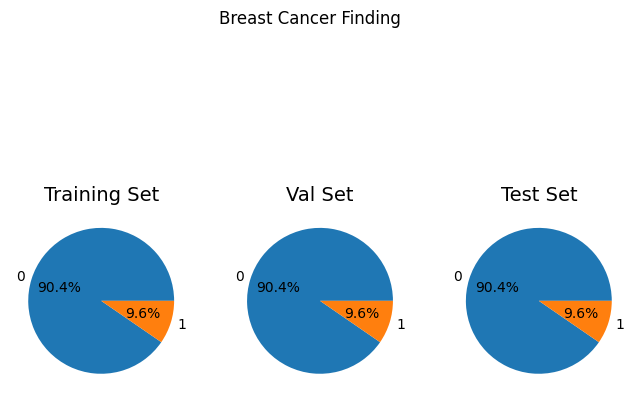

In [8]:
# label distributions
import matplotlib.pyplot as plt
value = train_df['label'].value_counts()
fig, axs = plt.subplots(1, 3, figsize=(8, 6))
fig.suptitle('Breast Cancer Finding')
axs[0].pie(value, labels=value.index, autopct='%1.1f%%')
axs[0].set_title('Training Set', fontsize=14)

# label distributions
value_1 = val_df['label'].value_counts()
axs[1].pie(value_1, labels=value_1.index, autopct='%1.1f%%')
axs[1].set_title('Val Set', fontsize=14)

# label distributions
value_2 = test_df['label'].value_counts()
axs[2].pie(value_2, labels=value_2.index, autopct='%1.1f%%')
axs[2].set_title('Test Set', fontsize=14)

plt.show()

In [9]:
def create_gens(train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors.
    '''

    color = 'rgb'
    img_size = (224, 224)

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

    tr_gen = ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                zoom_range=0.2,
                                rotation_range=20,
                                fill_mode="constant")
    
    ts_gen = ImageDataGenerator()
    
    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image_path', y_col='label', 
                                           target_size=img_size, class_mode='categorical',
                                           color_mode=color, shuffle=True, batch_size=batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'image_path', y_col='label', 
                                           target_size=img_size, class_mode='categorical',
                                           color_mode=color, shuffle=False, batch_size=test_batch_size)

    test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'image_path', y_col='label', 
                                          target_size=img_size, class_mode='categorical',
                                          color_mode=color, shuffle=False, batch_size=test_batch_size)

    return train_gen, valid_gen, test_gen

## Visualize Dataset

In [10]:
batch_size = 64
train_gen, valid_gen, test_gen = create_gens(train_df, val_df, test_df, batch_size)

Found 16000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


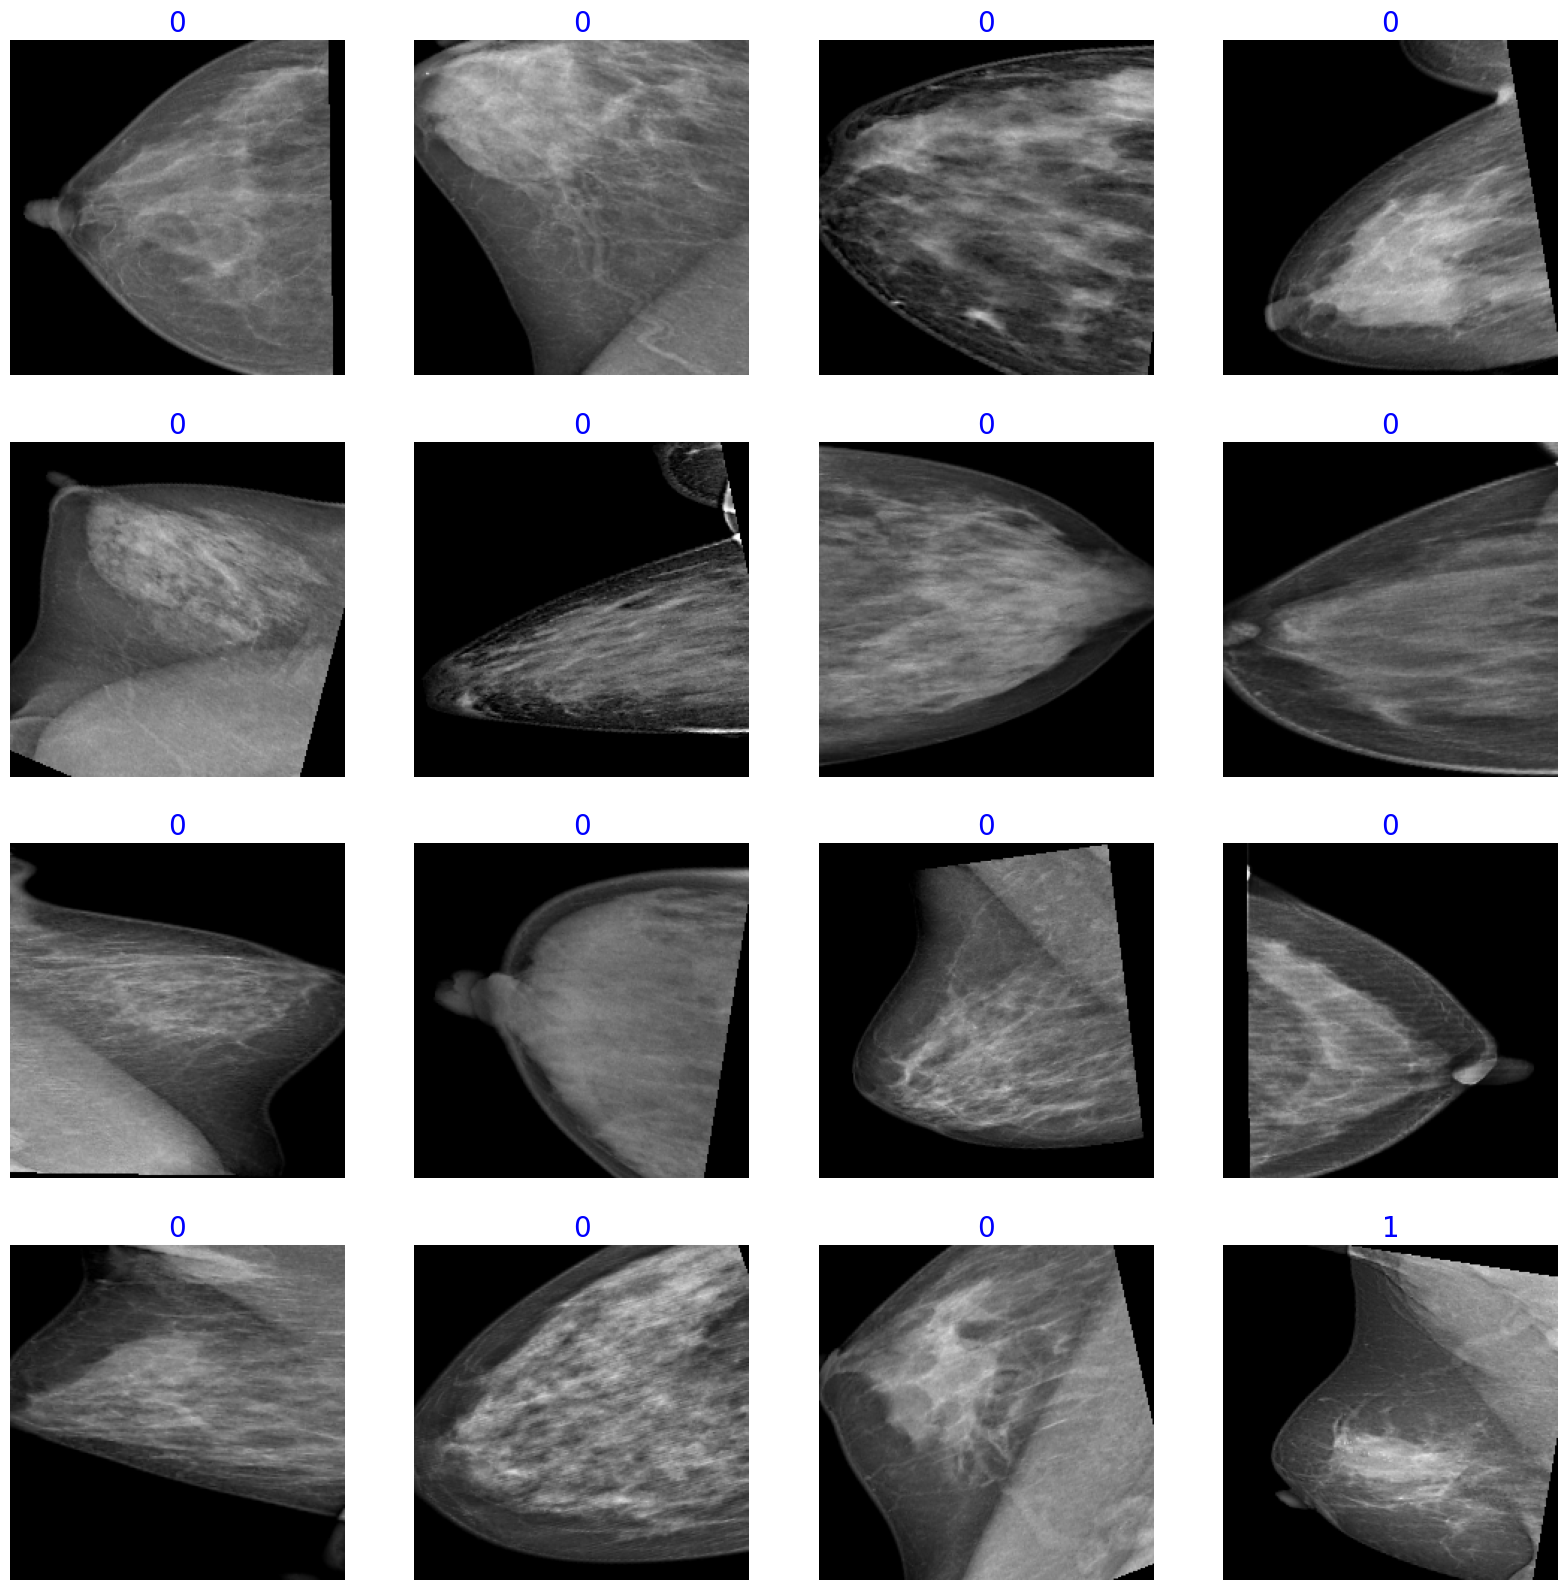

In [11]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color='blue' , fontsize=20)
    plt.axis('off')
plt.show()

## Model ----------

In [12]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

base_model = tf.keras.applications.densenet.DenseNet121(include_top=False,
                                                        weights="imagenet",
                                                        input_shape=img_shape, 
                                                        pooling='max')


model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(1024, kernel_regularizer=regularizers.l2(0.02),
               activity_regularizer=regularizers.l1(0.006),
               bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45),
    BatchNormalization(),
    Dense(512, kernel_regularizer=regularizers.l2(0.001),
               activity_regularizer=regularizers.l1(0.001),
               bias_regularizer=regularizers.l1(0.001), activation='relu'),
    Dense(class_count, activation='softmax')])

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics= [tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.AUC(curve='ROC', name='auc'),
                        tf.keras.metrics.AUC(curve='PR', name='pr_auc'),
                        'accuracy'])

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                         

In [13]:
import os
output_dir = '/kaggle/working/output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

early_stopping = EarlyStopping(monitor='val_recall', patience=5, mode='max', verbose=1)

# class_weights = compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weights = compute_class_weight({0: 0.55302088, 1: 6.21512386}, 
                                     classes=np.unique(train_gen.classes), 
                                     y=train_gen.classes)
class_weights

array([0.55302088, 6.21512386])

In [15]:
epochs = 50
history = model.fit(train_gen, epochs=epochs, verbose=1,
                    validation_data= valid_gen,
                    validation_steps=None, shuffle=False,
                    class_weight=dict(enumerate(class_weights)),
                    callbacks=[early_stopping]
                    )

Epoch 1/50


I0000 00:00:1710771158.870099      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 887s 3s/step - loss: 16.2318 - FN: 8666.0000 - TP: 7334.0000 - recall: 0.4584 - precision: 0.4584 - auc: 0.4513 - pr_auc: 0.4675 - accuracy: 0.4584 - val_loss: 12.9942 - val_FN: 303.0000 - val_TP: 1697.0000 - val_recall: 0.8485 - val_precision: 0.8485 - val_auc: 0.8945 - val_pr_auc: 0.8808 - val_accuracy: 0.8485
Epoch 2/50
250/250 [==============================] - 580s 2s/step - loss: 11.7009 - FN: 8139.0000 - TP: 7861.0000 - recall: 0.4913 - precision: 0.4913 - auc: 0.4932 - pr_auc: 0.4979 - accuracy: 0.4913 - val_loss: 10.5657 - val_FN: 1102.0000 - val_TP: 898.0000 - val_recall: 0.4490 - val_precision: 0.4490 - val_auc: 0.5181 - val_pr_auc: 0.5725 - val_accuracy: 0.4490
Epoch 3/50
250/250 [==============================] - 580s 2s/step - loss: 9.8367 - FN: 7776.0000 - TP: 8224.0000 - recall: 0.5140 - precision: 0.5140 - auc: 0.5240 - pr_auc: 0.5219 - accuracy: 0.5140 - val_loss: 9.0624 - val_FN: 470.0000 - val_TP: 1530.0000 - val_recall: 0.

In [16]:
model.save_weights(f'{output_dir}/model_weights.h5')
val_df.to_csv(f'{output_dir}/val_df.csv')
test_df.to_csv(f'{output_dir}/test_df.csv')

## Visualize model training process

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

recall = history.history['recall']
val_recall = history.history['val_recall']

precision = history.history['precision']
val_precision = history.history['val_precision']

auc = history.history['auc']
val_auc = history.history['val_auc']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(recall))

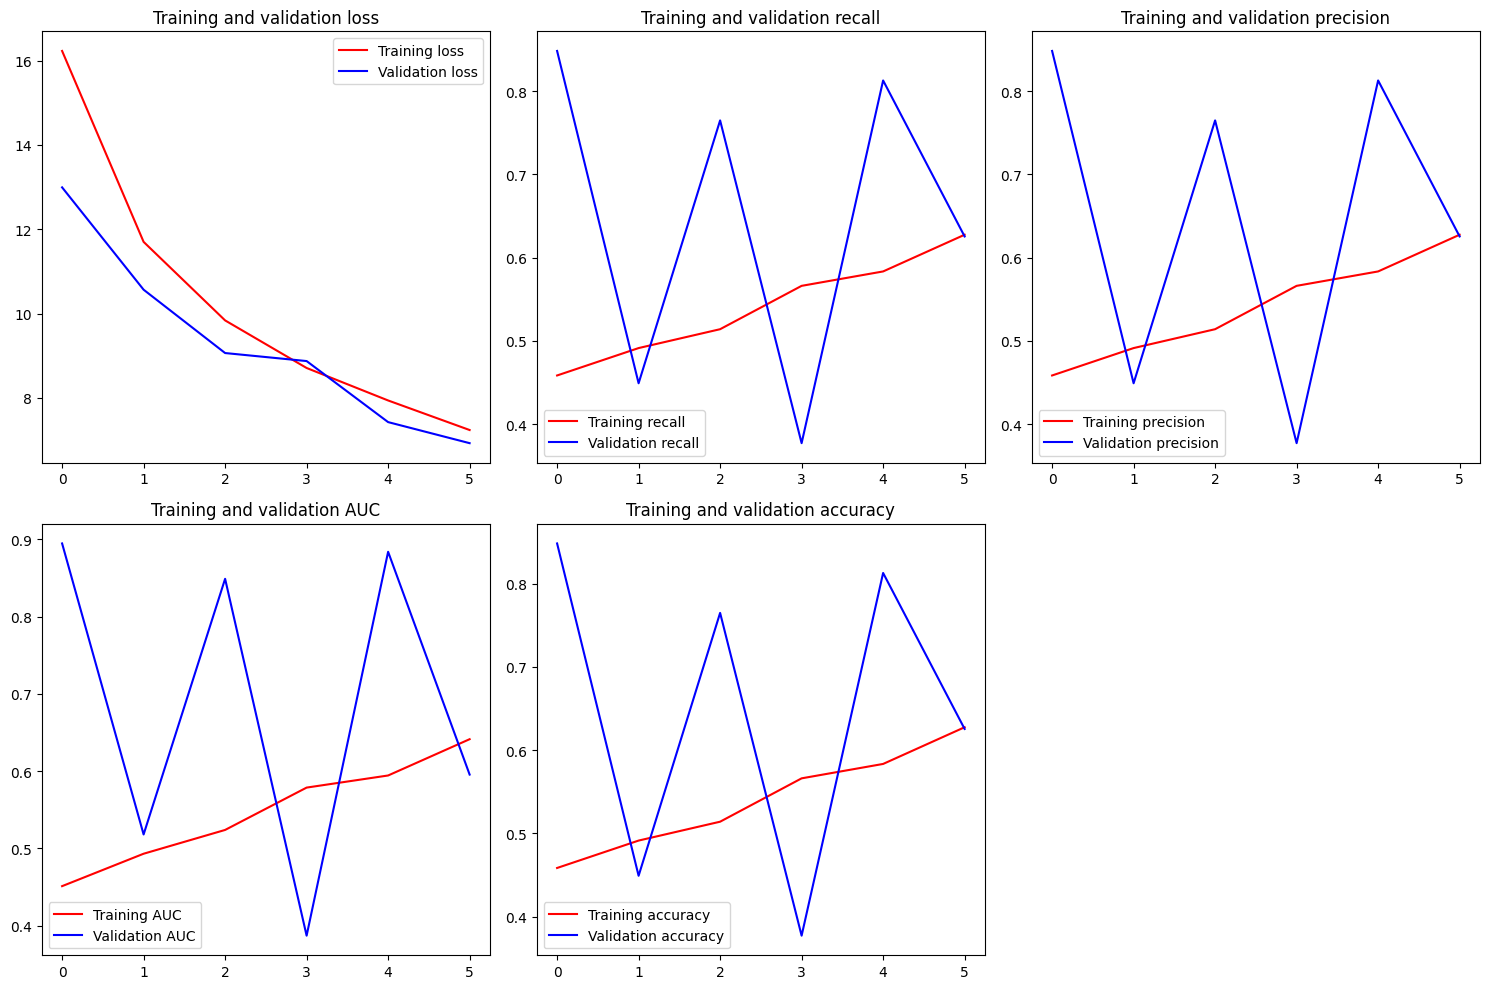

In [18]:
# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plotting 
axs[0, 0].plot(epochs, loss, 'r', label='Training loss')
axs[0, 0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0, 0].set_title('Training and validation loss')
axs[0, 0].legend(loc=0)

axs[0, 1].plot(epochs, recall, 'r', label='Training recall')
axs[0, 1].plot(epochs, val_recall, 'b', label='Validation recall')
axs[0, 1].set_title('Training and validation recall')
axs[0, 1].legend(loc=0)

axs[0, 2].plot(epochs, precision, 'r', label='Training precision')
axs[0, 2].plot(epochs, val_precision, 'b', label='Validation precision')
axs[0, 2].set_title('Training and validation precision')
axs[0, 2].legend(loc=0)
# Hide the empty subplot
# axs[0, 2].axis('off')

axs[1, 0].plot(epochs, auc, 'r', label='Training AUC')
axs[1, 0].plot(epochs, val_auc, 'b', label='Validation AUC')
axs[1, 0].set_title('Training and validation AUC')
axs[1, 0].legend(loc=0)
# axs[1, 0].axis('off')

axs[1, 1].plot(epochs, accuracy, 'r', label='Training accuracy')
axs[1, 1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
axs[1, 1].set_title('Training and validation accuracy')
axs[1, 1].legend(loc=0)
# axs[1, 1].axis('off')


# Hide the empty subplot
axs[1, 2].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Evaluate model

In [19]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

25/25 [==============================] - 78s 3s/step - loss: 6.9208 - FN: 747.0000 - TP: 1253.0000 - recall: 0.6265 - precision: 0.6265 - auc: 0.5879 - pr_auc: 0.5498 - accuracy: 0.6265


## Get Predictions

In [20]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
print(preds)
print(y_pred)

25/25 [==============================] - 51s 2s/step
[[0.25881028 0.7411898 ]
 [0.5201658  0.47983414]
 [0.33390403 0.66609603]
 ...
 [0.5025921  0.49740785]
 [0.51717174 0.48282826]
 [0.44115427 0.5588457 ]]
[1 0 1 ... 0 0 1]


In [21]:
# Save model predction to csv
# Get filenames from the test generator
filenames = test_gen.filenames

# Assuming y_pred is the predicted class (use argmax to get class labels)
y_pred_class = y_pred

# Create a DataFrame with predictions, true labels, and predicted probabilities for each class
results = pd.DataFrame({
    "img_path": filenames,
    "true_class": y_true,
    "predicted_class": y_pred_class,
    "prob_class_0": preds[:, 0],  # Probability for class 0
    "prob_class_1": preds[:, 1]   # Probability for class 1
})

# Save the DataFrame to a CSV file
results.to_csv(f"{output_dir}/prediction_result.csv", index=False)
results

,img_path,true_class,predicted_class,prob_class_0,prob_class_1
0,/kaggle/input/full-fullsize/png/png/b2979c0f7f...,1,1,0.258810,0.741190
1,/kaggle/input/full-fullsize/png/png/d0322ac757...,0,0,0.520166,0.479834
2,/kaggle/input/full-fullsize/png/png/1fe77db1e4...,0,1,0.333904,0.666096
3,/kaggle/input/full-fullsize/png/png/2db80265d2...,0,0,0.515899,0.484101
4,/kaggle/input/full-fullsize/png/png/d90bbc67c7...,0,0,0.502029,0.497971
...,...,...,...,...,...
1995,/kaggle/input/full-fullsize/png/png/4f2dbafc34...,0,1,0.211647,0.788353
1996,/kaggle/input/full-fullsize/png/png/9b7e001b3a...,0,0,0.526584,0.473416
1997,/kaggle/input/full-fullsize/png/png/fbc135926b...,0,0,0.502592,0.497408
1998,/kaggle/input/full-fullsize/png/png/80c50f0ade...,0,0,0.517172,0.482828


### Confusion Matrics and Classification Report

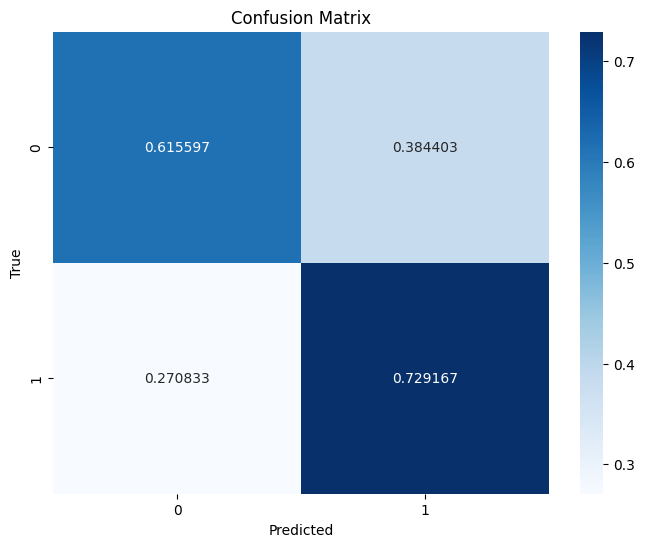

In [22]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

           0       0.96      0.62      0.75      1808
           1       0.17      0.73      0.27       192

    accuracy                           0.63      2000
   macro avg       0.56      0.67      0.51      2000
weighted avg       0.88      0.63      0.70      2000



r 0.69 - p 0.61 - f 0.63 -

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# Assuming y_true and y_pred are your true labels and predicted labels
# and conf_matrix is your confusion matrix

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate Sensitivity and Specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print the results
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")

# Calculate AUC
auc = roc_auc_score(y_true, y_pred)
print(f"AUC: {auc:.4f}")

# Calculate PRAUC
pr_auc = average_precision_score(y_true, y_pred)
print(f"PRAUC: {pr_auc:.4f}")
print("-------- Binary -------")
print("F1 Score: {:.4f}".format(f1_score(y_true, y_pred, average='binary')))
print("Recall score: {:.4f}".format(recall_score(y_true, y_pred, average='binary')))
print("Precision score: {:.4f}".format(precision_score(y_true, y_pred, average='binary')))
print("-------- Macro -------")
print("F1 Score: {:.4f}".format(f1_score(y_true, y_pred, average='macro')))
print("Recall score: {:.4f}".format(recall_score(y_true, y_pred, average='macro')))
print("Precision score: {:.4f}".format(precision_score(y_true, y_pred, average='macro')))

Sensitivity (True Positive Rate): 0.7292
Specificity (True Negative Rate): 0.6156
AUC: 0.6724
PRAUC: 0.1483
-------- Binary -------
F1 Score: 0.2726
Recall score: 0.7292
Precision score: 0.1677
-------- Macro -------
F1 Score: 0.5107
Recall score: 0.6724
Precision score: 0.5615


### AUC 

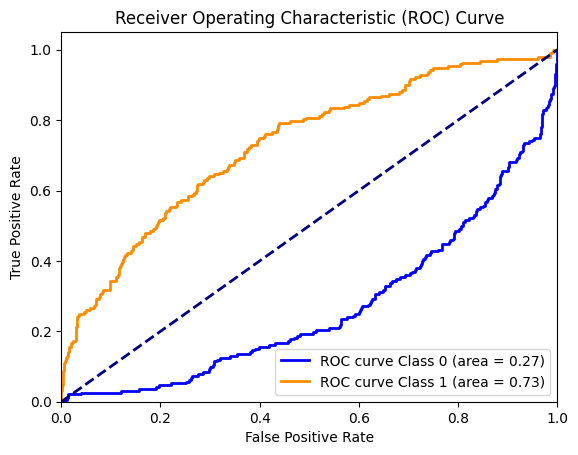

Macro Average AUC: 0.5


In [25]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, PrecisionRecallDisplay

# Extract scores for both classes
y_scores_class_0 = preds[:, 0]
y_scores_class_1 = preds[:, 1]

# Calculate ROC curve and AUC for class 0
fpr_0, tpr_0, _ = roc_curve(y_true, y_scores_class_0)
roc_auc_0 = auc(fpr_0, tpr_0)

# Calculate ROC curve and AUC for class 1
fpr_1, tpr_1, _ = roc_curve(y_true, y_scores_class_1)
roc_auc_1 = auc(fpr_1, tpr_1)

# Plot ROC curve for class 0
plt.plot(fpr_0, tpr_0, color='blue', lw=2, label='ROC curve Class 0 (area = %0.2f)' % roc_auc_0)

# Plot ROC curve for class 1
plt.plot(fpr_1, tpr_1, color='darkorange', lw=2, label='ROC curve Class 1 (area = %0.2f)' % roc_auc_1)

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot labels and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate macro-average AUC
macro_auc = (roc_auc_0 + roc_auc_1) / 2
print("Macro Average AUC:", macro_auc)

### PR Curve

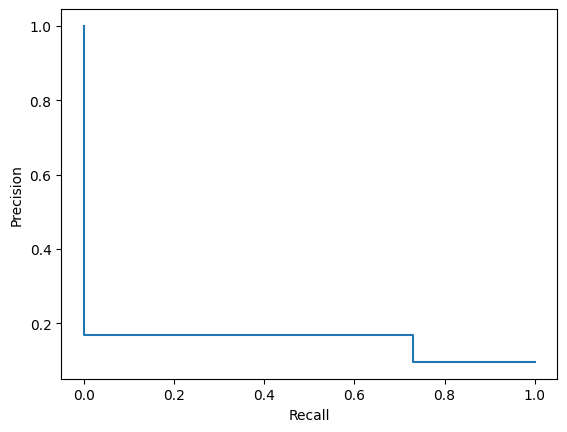

In [26]:
precision, recall, _ = precision_recall_curve(y_true, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

## **Incorrect predictions**

In [27]:
incorrect_predictions = results[results['true_class'] != results['predicted_class']]
incorrect_predictions

,img_path,true_class,predicted_class,prob_class_0,prob_class_1
2,/kaggle/input/full-fullsize/png/png/1fe77db1e4...,0,1,0.333904,0.666096
11,/kaggle/input/full-fullsize/png/png/f5c548e47e...,1,0,0.501524,0.498476
12,/kaggle/input/full-fullsize/png/png/00dfcde5aa...,0,1,0.498514,0.501486
17,/kaggle/input/full-fullsize/png/png/d176abcedc...,0,1,0.468866,0.531134
19,/kaggle/input/full-fullsize/png/png/fb3c1cc19b...,0,1,0.486767,0.513233
...,...,...,...,...,...
1984,/kaggle/input/full-fullsize/png/png/e3ea477f6b...,1,0,0.505798,0.494202
1989,/kaggle/input/full-fullsize/png/png/3f14fe0877...,0,1,0.305728,0.694272
1992,/kaggle/input/full-fullsize/png/png/4bd6ad56e1...,0,1,0.171954,0.828046
1993,/kaggle/input/full-fullsize/png/png/b719ac3962...,0,1,0.441863,0.558137


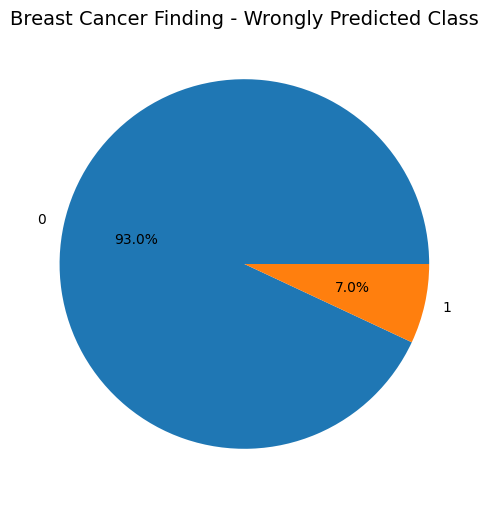

In [28]:
value = incorrect_predictions['true_class'].value_counts()
plt.figure(figsize=(8, 6))
plt.title('Breast Cancer Finding - Wrongly Predicted Class', fontsize=14)
plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.show()

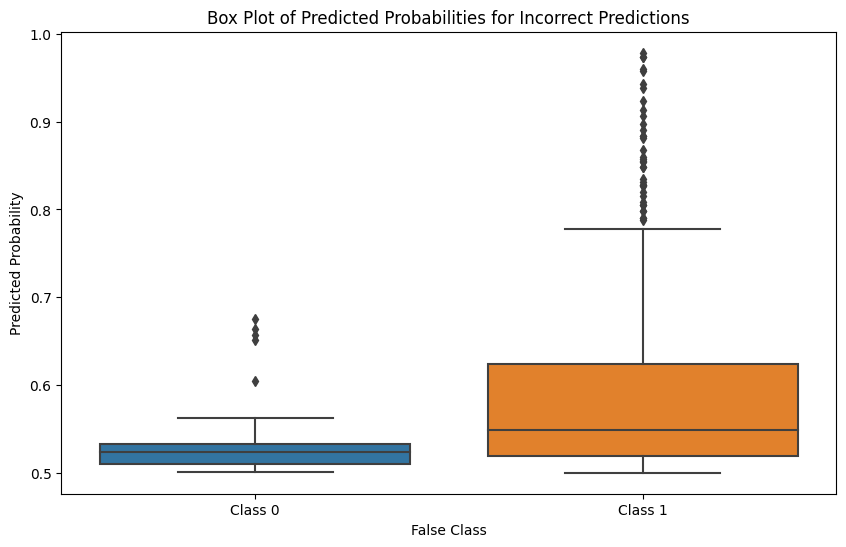

In [29]:
# Combine the predicted probabilities into a single DataFrame
probs_df =  pd.DataFrame({
    'Class 0': incorrect_predictions.loc[incorrect_predictions['prob_class_0'] >= 0.5, 'prob_class_0'],
    'Class 1': incorrect_predictions.loc[incorrect_predictions['prob_class_1'] >= 0.5, 'prob_class_1'],
})

# Box plot to compare the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.boxplot(data=probs_df)
plt.title('Box Plot of Predicted Probabilities for Incorrect Predictions')
plt.xlabel('False Class')
plt.ylabel('Predicted Probability')
plt.show()